In [0]:
import shutil,os
import cv2
import scipy.io
import tarfile
from six.moves.urllib import request

import numpy as np 
import tensorflow as tf
from tensorflow import keras


%matplotlib inline
import matplotlib.pyplot as plt

# Data Loading

In [0]:
# retrieve data from url
url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
filename = './flower_photos.tgz'

if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
tar = tarfile.open('flower_photos.tgz')
tar.extractall()
tar.close() 

input_file = os.path.abspath('flower_photos')

# Data Processing

In [0]:
# read files to all_labels and all_files
def preprocess_file(input_file):
    i=0
    flow_index = {}
    all_files = []
    all_labels = []

    for flower in sorted(os.listdir(input_file))[1:]:
        flow_index[i] = flower
        #flow_index.pop(4, None)
        all_labels += len(os.listdir(input_file+'/'+flower))*[i]
        for img in os.listdir(input_file+'/'+flower):
            all_files.append(input_file+'/'+flower+'/'+img)
        i+=1    
    return all_files, all_labels, flow_index



all_files, all_labels, flow_index = preprocess_file(input_file)
N_CLASSES = len(np.unique(all_labels))

In [4]:
flow_index

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [8]:
# spilt
from sklearn.model_selection import train_test_split
files, te_files, labels, te_labels = train_test_split(all_files, all_labels, test_size=0.2, stratify=all_labels)
tr_files, va_files, tr_labels, va_labels = train_test_split(files, labels, test_size=0.2, stratify=labels)
te_files[:10], [flow_index[i] for i in te_labels[:10]]

(['/content/flower_photos/daisy/2365428551_39f83f10bf_n.jpg',
  '/content/flower_photos/dandelion/8270191872_61e47ae3b8_m.jpg',
  '/content/flower_photos/roses/3903276582_fe05bf84c7_n.jpg',
  '/content/flower_photos/sunflowers/244074259_47ce6d3ef9.jpg',
  '/content/flower_photos/sunflowers/5330608174_b49f7a4c48_m.jpg',
  '/content/flower_photos/dandelion/2470874500_43d8011e75.jpg',
  '/content/flower_photos/daisy/835750256_3f91a147ef_n.jpg',
  '/content/flower_photos/roses/21522100663_455b77a90c_n.jpg',
  '/content/flower_photos/roses/4505921907_21c8002fde.jpg',
  '/content/flower_photos/tulips/112428665_d8f3632f36_n.jpg'],
 ['daisy',
  'dandelion',
  'roses',
  'sunflowers',
  'sunflowers',
  'dandelion',
  'daisy',
  'roses',
  'roses',
  'tulips'])

In [6]:
unique, counts1 = np.unique(tr_labels, return_counts=True)
unique, counts2 = np.unique(te_labels, return_counts=True)
dict(zip(unique, counts1/counts2))

{0: 3.188976377952756,
 1: 3.212290502793296,
 2: 3.203125,
 3: 3.192857142857143,
 4: 3.19375}

In [0]:
# create directories
os.mkdir(input_file+'/'+'train_dir')
os.mkdir(input_file+'/'+'validation_dir')
os.mkdir(input_file+'/'+'test_dir')
         
for i_class in flow_index.values():
    os.mkdir(input_file+'/'+'train_dir'+'/'+i_class)
    os.mkdir(input_file+'/'+'validation_dir'+'/'+i_class)
    os.mkdir(input_file+'/'+'test_dir'+'/'+i_class)

    
# move file
def move_file_to_dir(files,labels, sub_dir, input_file=input_file):
    for i,src in enumerate(files):
        dst = input_file+'/'+sub_dir+'/'+flow_index[labels[i]]
        shutil.copy(src, dst)
   

In [0]:
move_file_to_dir(tr_files, tr_labels,'train_dir')
move_file_to_dir(va_files, va_labels,  'validation_dir') 
move_file_to_dir(te_files, te_labels, 'test_dir') 

In [0]:
train_dir = input_file+'/'+'train_dir'
validation_dir = input_file+'/'+'validation_dir' 
test_dir = input_file+'/'+'test_dir'

#  Fine-Tuning  with Base Model: inception_v3

In [12]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
print('This is the number of trainable weights '
      'before freezing the base_model:', len(base_model.trainable_weights))

87916544/87910968 [==============================] - 2s 0us/step
This is the number of trainable weights before freezing the base_model: 188


In [0]:
# add layers
model = keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation = 'relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(N_CLASSES, activation="softmax"))


In [14]:
# fixed params to reduce computation
'''scape from online resource'''
# set all layers trainable by default  
for layer in base_model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
    
# fix deep layers (fine-tuning only last 25)
for layer in base_model.layers[:-25]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
        
# look at base_model     
print('This is the number of trainable weights '
      'after freezing the base_model:', len(base_model.trainable_weights))

This is the number of trainable weights after freezing the base_model: 100


In [16]:
# look at models
print(len(base_model.layers))
print(len(model.layers))

311
6


In [15]:
# data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')


Found 3176 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


In [0]:
# compile
model.compile(  loss = "categorical_crossentropy", 
                optimizer = keras.optimizers.RMSprop(lr=1e-3), 
                metrics = ["accuracy"] )

# Train and Test Model 

In [0]:
# prepare for train
checkpoint = keras.callbacks.ModelCheckpoint("ass3_flowers.h5", 
                                             monitor='val_acc', verbose=1, 
                                             save_best_only=True, 
                                             save_weights_only=False, mode='auto', period=1)


early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', 
                                               min_delta=0.001, patience=2, 
                                               verbose=1, mode='auto')

In [0]:
train = True
last_finished_epoch = 0 

In [21]:
# train
if train:
    history = model.fit_generator(train_generator, 
        steps_per_epoch= 100,
        epochs=50,
        validation_data=validation_generator, 
        validation_steps=25 , 
        callbacks=[checkpoint, early_stopping],
        verbose=1,
        initial_epoch=last_finished_epoch)
    model.save_weights('epochs_weights.h5')

Epoch 1/50
 99/100 [============================>.] - ETA: 4s - loss: 0.9525 - acc: 0.6983
Epoch 00001: val_acc improved from -inf to 0.82400, saving model to ass3_flowers.h5
100/100 [==============================] - 456s 5s/step - loss: 0.9474 - acc: 0.6993 - val_loss: 0.5190 - val_acc: 0.8240
Epoch 2/50
 99/100 [============================>.] - ETA: 4s - loss: 0.8770 - acc: 0.6818
Epoch 00002: val_acc did not improve from 0.82400
100/100 [==============================] - 457s 5s/step - loss: 0.8729 - acc: 0.6840 - val_loss: 0.5557 - val_acc: 0.8160
Epoch 3/50
 99/100 [============================>.] - ETA: 4s - loss: 0.9058 - acc: 0.6677
Epoch 00003: val_acc improved from 0.82400 to 0.84400, saving model to ass3_flowers.h5
100/100 [==============================] - 463s 5s/step - loss: 0.9047 - acc: 0.6670 - val_loss: 0.4305 - val_acc: 0.8440
Epoch 4/50
 99/100 [============================>.] - ETA: 4s - loss: 0.7218 - acc: 0.7394
Epoch 00004: val_acc improved from 0.84400 to 0.8

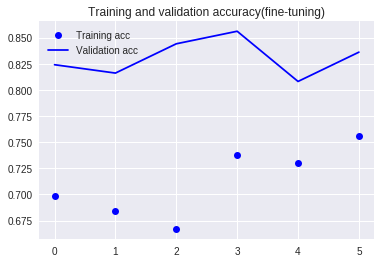

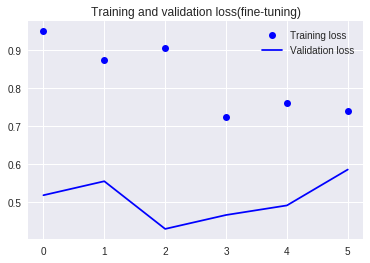

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(fine-tuning)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(fine-tuning)')
plt.legend()

plt.show()

In [24]:
# test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        batch_size=20,
        class_mode='categorical')


score = model.evaluate_generator(test_generator, steps=50)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

Found 734 images belonging to 5 classes.
Test loss: 0.6304232575771375
Test accuracy: 0.8319919578266336
